In [1]:
import torch

import numpy as np
import matplotlib.pyplot as plt

from counterfactual_xai.utils.clue.bnn.gaussian_bnn import GaussianBNN
from counterfactual_xai.utils.clue.gaussian_mlp import GaussianMLP
from counterfactual_xai.utils.clue.vae.gaussian_vae import GaussianVAE
from counterfactual_xai.utils.datafeed import DataFeed
from counterfactual_xai.utils.mimic_dataloader import MimiDataLoader
from counterfactual_xai.methods.interpretation import latent_project_gauss, gen_bar_plot
from counterfactual_xai.methods.utils import LnDistance
from counterfactual_xai.methods.clue import decompose_entropy_cat, decompose_std_gauss, CLUE

INFO:numexpr.utils:Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
CSV_PATH = "./../data/"
save_dir = "/Users/lukasscholz/repositorys/studienprojekt/counterfactuals/data/mimic/results/_model_mort_icu_cleaned/state_dicts.pkl"

cuda = False
device: str = "cuda" if cuda else "cpu"
learning_rate = 1e-2

# MLP

In [3]:
INPUT_DIMS = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 41]
print(sum(INPUT_DIMS))

59


In [4]:
# INPUT_DIMS = [1, 1, 8, 2]
# INPUT_DIMS = [5, 5, 41, 10]
# INPUT_DIMs bestehen aus 18 einzelnen Kategorien (hadm_id, age, max_hours, etc.) 2 one-hot Kategorien (gender_F, gender_M) und 41 one-hot Kategorien (ethnicity)
# INPUT_DIMS = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 41]

x_train, x_test, x_means, x_stds, y_train, y_test, y_means, y_stds, DATA_KEYS, input_dims = MimiDataLoader(INPUT_DIMS,
                                                                                                           CSV_PATH).get_mimic_dataset()

trainset = DataFeed(x_train, y_train, transform=None)
valset = DataFeed(x_test, y_test, transform=None)

input_dim = x_train.shape[1]
width = 200
depth = 2
output_dim = y_train.shape[1]

mlp_gauss = GaussianMLP(input_dim, width, depth, output_dim, flatten_image=False)
print(mlp_gauss.eval())

GaussianMLP(
  (block): Sequential(
    (0): Linear(in_features=59, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=2, bias=True)
  )
)


# BNN

In [5]:
N_train = x_train.shape[0]

bnn_gauss = GaussianBNN(mlp_gauss, N_train, lr=learning_rate, cuda=cuda)
bnn_gauss.load_weights(save_dir)

Total params: 0.05M


# VAE

In [6]:
INPUT_DIMS

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 41]

In [7]:
width = 300
depth = 3
latent_dim = 4

lr = 1e-4
VAE = GaussianVAE(INPUT_DIMS, width, depth, latent_dim, pred_sig=False,
                  lr=lr, cuda=cuda, flatten=False)

VAE.load(
    filename="/Users/lukasscholz/repositorys/studienprojekt/counterfactuals/data/mimic/saves/fc_preact_VAE_d2_lsat_models_4/_models/theta_best.dat",
    device=device)


INFO:root:Loading: /Users/lukasscholz/repositorys/studienprojekt/counterfactuals/data/mimic/saves/fc_preact_VAE_d2_lsat_models_4/_models/theta_best.dat


    Total params: 0.40M
  restoring epoch: 707, lr: 0.000100


707

# Visualizations

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/lukasscholz/opt/anaconda3/envs/counterfactuals/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/lukasscholz/opt/anaconda3/envs/counterfactuals/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(

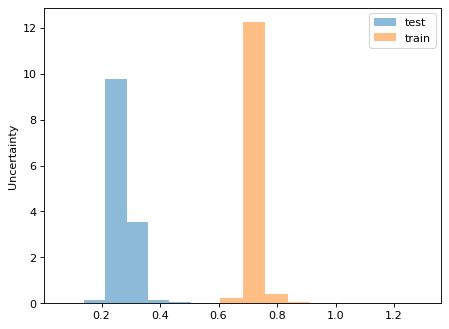

In [8]:
tr_aleatoric_vec, tr_epistemic_vec, z_train, x_train, y_train = latent_project_gauss(bnn_gauss, VAE, dset=trainset,
                                                                                     batch_size=2048, cuda=cuda, prob_BNN=False)

tr_uncertainty_vec = tr_aleatoric_vec + tr_epistemic_vec

te_aleatoric_vec, te_epistemic_vec, z_test, x_test, y_test = latent_project_gauss(bnn_gauss, VAE, dset=valset,
                                                                                  batch_size=2048, cuda=cuda)

te_uncertainty_vec = (te_aleatoric_vec ** 2 + te_epistemic_vec ** 2) ** (1.0 / 2)

uncertainty_idxs_sorted = np.flipud(np.argsort(te_uncertainty_vec))
aleatoric_idxs_sorted = np.flipud(np.argsort(te_aleatoric_vec))
epistemic_idxs_sorted = np.flipud(np.argsort(te_epistemic_vec))

plt.figure(dpi=80)
plt.hist(te_uncertainty_vec, density=True, alpha=0.5)
plt.hist(tr_uncertainty_vec, density=True, alpha=0.5)
plt.legend(['test', 'train'])
plt.ylabel('Uncertainty')
plt.show()

# Uncertainty per Dimension / Feature

In [9]:
dname = "mimic"
# var_names = {"mimic": ['LSAT', 'UGPA', 'race', 'sex']}
var_names_flat = {
    "mimic": ["age", "max_hours", "vent", "vaso", "adenosine", "dobutamine", "dopamine",
              "epinephrine", "isuprel",
              "milrinone", "norepinephrine", "phenylephrine", "vasopressin", "colloid_bolus", "crystalloid_bolus",
              "nivdurations", "gender_F",
              "gender_M", "ethnicity_AMERICAN INDIAN/ALASKA NATIVE",
              "ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE",
              "ethnicity_ASIAN", "ethnicity_ASIAN - ASIAN INDIAN", "ethnicity_ASIAN - CAMBODIAN",
              "ethnicity_ASIAN - CHINESE",
              "ethnicity_ASIAN - FILIPINO", "ethnicity_ASIAN - JAPANESE", "ethnicity_ASIAN - KOREAN",
              "ethnicity_ASIAN - OTHER",
              "ethnicity_ASIAN - THAI", "ethnicity_ASIAN - VIETNAMESE", "ethnicity_BLACK/AFRICAN",
              "ethnicity_BLACK/AFRICAN AMERICAN",
              "ethnicity_BLACK/CAPE VERDEAN", "ethnicity_BLACK/HAITIAN", "ethnicity_CARIBBEAN ISLAND",
              "ethnicity_HISPANIC OR LATINO",
              "ethnicity_HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)", "ethnicity_HISPANIC/LATINO - COLOMBIAN",
              "ethnicity_HISPANIC/LATINO - CUBAN",
              "ethnicity_HISPANIC/LATINO - DOMINICAN", "ethnicity_HISPANIC/LATINO - GUATEMALAN",
              "ethnicity_HISPANIC/LATINO - HONDURAN",
              "ethnicity_HISPANIC/LATINO - MEXICAN", "ethnicity_HISPANIC/LATINO - PUERTO RICAN",
              "ethnicity_HISPANIC/LATINO - SALVADORAN",
              "ethnicity_MIDDLE EASTERN", "ethnicity_MULTI RACE ETHNICITY",
              "ethnicity_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER",
              "ethnicity_OTHER", "ethnicity_PATIENT DECLINED TO ANSWER", "ethnicity_PORTUGUESE",
              "ethnicity_SOUTH AMERICAN",
              "ethnicity_UNABLE TO OBTAIN", "ethnicity_UNKNOWN/NOT SPECIFIED", "ethnicity_WHITE",
              "ethnicity_WHITE - BRAZILIAN",
              "ethnicity_WHITE - EASTERN EUROPEAN", "ethnicity_WHITE - OTHER EUROPEAN", "ethnicity_WHITE - RUSSIAN"]
}

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/lukasscholz/opt/anaconda3/envs/counterfactuals/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/lukasscholz/opt/anaconda3/envs/counterfactuals/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/lukasscholz/opt/anaconda3/envs/counterfactuals/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', va

Text(0.5, 1.0, 'epistemic')

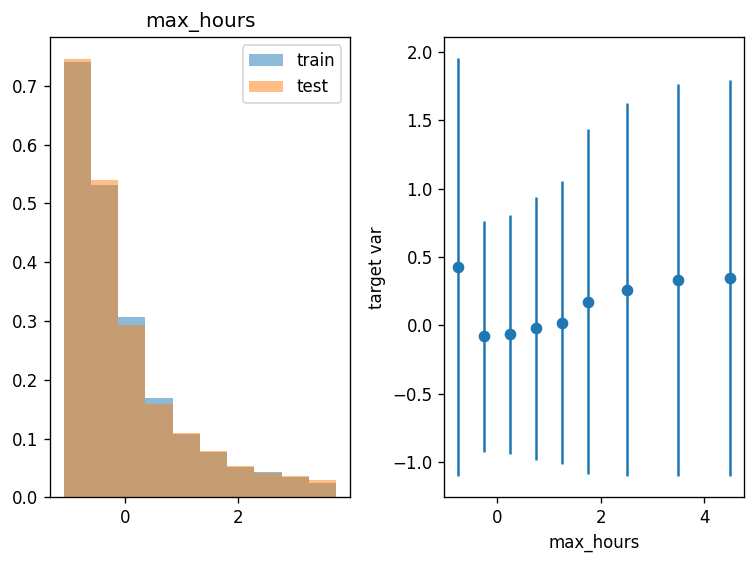

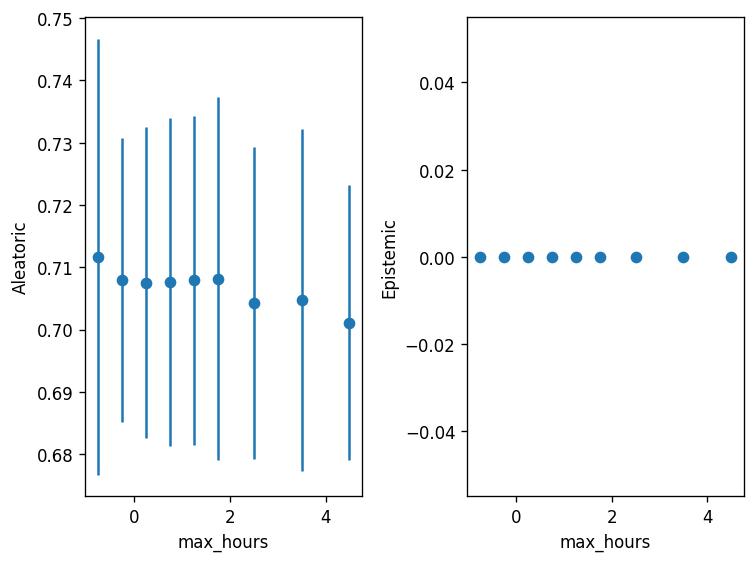

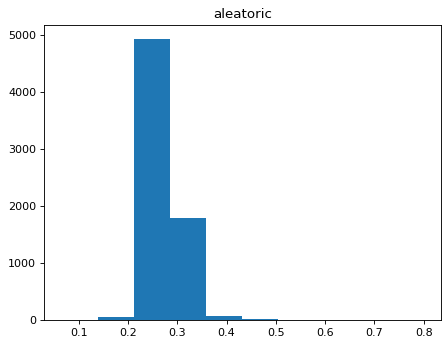

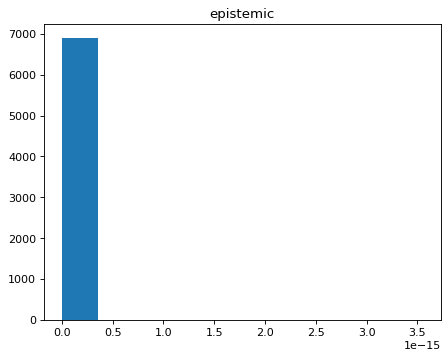

In [10]:
# var_N: Which Variable I want to analyze
var_N = 1

fig, axes = plt.subplots(1, 2, dpi=120)
# plt.figure(dpi=80)
axes[0].hist(x_train[:, var_N], density=True, alpha=0.5)
axes[0].hist(x_test[:, var_N], density=True, alpha=0.5)
axes[0].legend(['train', 'test'])
axes[0].set_title(var_names_flat[dname][var_N])

bins = [-5, -4, -3, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3, 4, 5]
center_bins = ((np.array([0] + bins) + np.array(bins + [0])) / 2)[1:]
center_bins[-1] = bins[-1]

bin_idx = np.digitize(x_train[:, var_N], bins, right=False)
bin_means = []
bin_stds = []
aleatoric_mean = []
aleatoric_stds = []
epistemic_mean = []
epistemic_stds = []

for n_bin, bin_start in enumerate(bins):
    y_select = y_train[bin_idx == n_bin]
    aleatoric_select = tr_aleatoric_vec[bin_idx == n_bin]
    epistemic_select = tr_epistemic_vec[bin_idx == n_bin]
    if len(y_select) == 0:
        bin_means.append(np.nan)
        bin_stds.append(np.nan)
        aleatoric_mean.append(np.nan)
        aleatoric_stds.append(np.nan)
        epistemic_mean.append(np.nan)
        epistemic_stds.append(np.nan)
    else:
        bin_means.append(y_select.mean())
        bin_stds.append(y_select.std())
        aleatoric_mean.append(aleatoric_select.mean())
        aleatoric_stds.append(aleatoric_select.std())
        epistemic_mean.append(epistemic_select.mean())
        epistemic_stds.append(epistemic_select.std())

# plt.figure(dpi=80)
axes[1].errorbar(center_bins, bin_means, yerr=bin_stds, fmt='o')
axes[1].set_xlabel(var_names_flat[dname][var_N])
axes[1].set_ylabel('target var')

plt.tight_layout()

fig, axes = plt.subplots(1, 2, dpi=120)
# plt.figure(dpi=80)
axes[0].errorbar(center_bins, aleatoric_mean, yerr=aleatoric_stds, fmt='o')
axes[0].set_xlabel(var_names_flat[dname][var_N])
axes[0].set_ylabel('Aleatoric')
# plt.show()

# plt.figure(dpi=80)
axes[1].errorbar(center_bins, epistemic_mean, yerr=epistemic_stds, fmt='o')
axes[1].set_xlabel(var_names_flat[dname][var_N])
axes[1].set_ylabel('Epistemic')

plt.tight_layout()
# plt.show()

plt.figure(dpi=80)
plt.hist(te_aleatoric_vec)
plt.title('aleatoric')

plt.figure(dpi=80)
plt.hist(te_epistemic_vec)
plt.title('epistemic')


# CLUE

In [11]:
use_index = uncertainty_idxs_sorted

Nbatch = 512
z_init_batch = z_test[use_index[:Nbatch]]
x_init_batch = x_test[use_index[:Nbatch]]
y_init_batch = y_test[use_index[:Nbatch]]

it 45, all conditions met, stopping
it 46, all conditions met, stopping
it 47, all conditions met, stopping
it 48, all conditions met, stopping
it 49, all conditions met, stopping
it 50, all conditions met, stopping
it 51, all conditions met, stopping
it 52, all conditions met, stopping
it 53, all conditions met, stopping
it 54, all conditions met, stopping
it 55, all conditions met, stopping
it 56, all conditions met, stopping
it 57, all conditions met, stopping
it 58, all conditions met, stopping
it 59, all conditions met, stopping
it 60, all conditions met, stopping
it 61, all conditions met, stopping
it 62, all conditions met, stopping
it 63, all conditions met, stopping
it 64, all conditions met, stopping
it 65, all conditions met, stopping
it 66, all conditions met, stopping
it 67, all conditions met, stopping
it 68, all conditions met, stopping
it 69, all conditions met, stopping
it 70, all conditions met, stopping
it 71, all conditions met, stopping
it 72, all conditions met, s

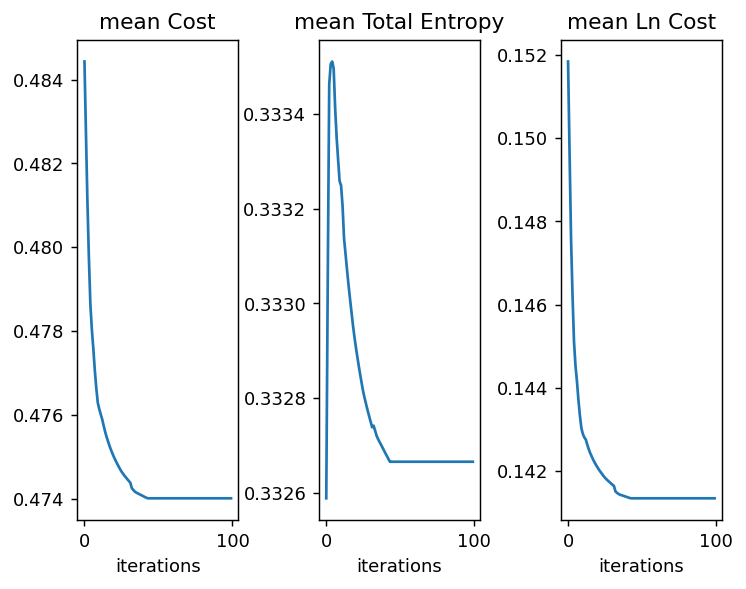

In [12]:
from counterfactual_xai.methods.clue import CLUE

torch.autograd.set_detect_anomaly(True)
torch.cuda.empty_cache()

dist = LnDistance(n=1, dim=1)
x_dim = x_init_batch.reshape(x_init_batch.shape[0], -1).shape[1]

aleatoric_weight = 0
epistemic_weight = 0
uncertainty_weight = 1

# Both weights are set to 1?
# distance_weight = 1.5 / x_dim
distance_weight = 1.5 / x_dim
prediction_similarity_weight = 0

mu_vec, std_vec = bnn_gauss.sample_predict(x_init_batch, 0, grad=False)
o_uncert, o_aleatoric, o_epistemic = decompose_std_gauss(mu_vec, std_vec)
desired_preds = mu_vec.mean(dim=0).cpu().numpy()

CLUE_explainer = CLUE(VAE, bnn_gauss, x_init_batch, uncertainty_weight=uncertainty_weight,
                      aleatoric_weight=aleatoric_weight, epistemic_weight=epistemic_weight,
                      prior_weight=0, distance_weight=distance_weight,
                      latent_L2_weight=0, prediction_similarity_weight=prediction_similarity_weight,
                      lr=1e-2, desired_preds=None, cond_mask=None, distance_metric=dist,
                      z_init=z_init_batch, norm_MNIST=False,
                      flatten_BNN=False, regression=True, cuda=False)

torch.autograd.set_detect_anomaly(False)

# clue_instance.optimizer = SGD(self.trainable_params, lr=lr, momentum=0.5, nesterov=True)
z_vec, x_vec, uncertainty_vec, epistemic_vec, aleatoric_vec, cost_vec, dist_vec = CLUE_explainer.optimise(
    min_steps=3, max_steps=100,
    n_early_stop=3)

fig, axes = plt.subplots(1, 3, dpi=130)
axes[0].plot(cost_vec.mean(axis=1))
axes[0].set_title('mean Cost')
axes[0].set_xlabel('iterations')

axes[1].plot(uncertainty_vec.mean(axis=1))
axes[1].set_title('mean Total Entropy')
axes[1].set_xlabel('iterations')

axes[2].plot(dist_vec.mean(axis=1))
axes[2].set_title('mean Ln Cost')
axes[2].set_xlabel('iterations')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)


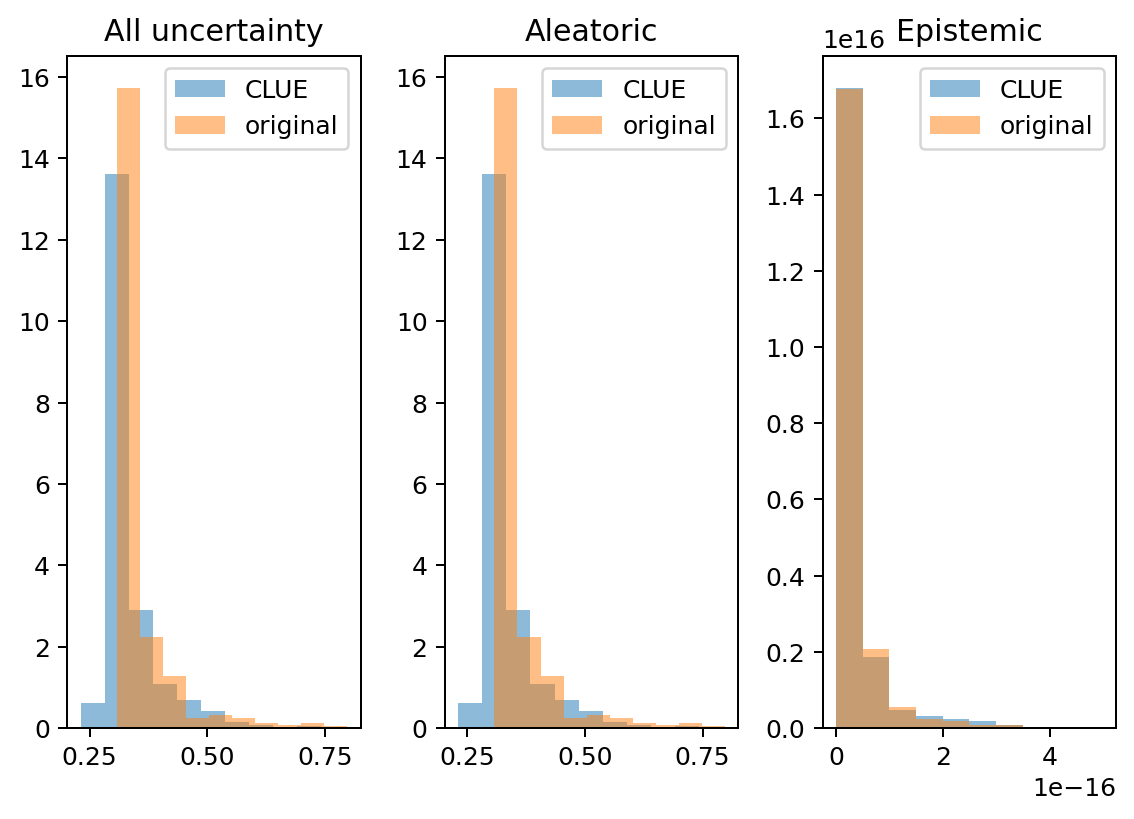

In [13]:
mu_vec, std_vec = bnn_gauss.sample_predict(x_vec[-1], num_samples=0, grad=False)
post_uncert, post_aleatoric, post_epistemic = decompose_std_gauss(mu_vec, std_vec)
post_preds = mu_vec.mean(dim=0).detach().cpu().numpy()

fig, axes = plt.subplots(1, 3, dpi=180)

axes[0].hist(post_uncert.detach().cpu().numpy(), density=True, alpha=0.5, label='CLUE')
axes[0].hist(te_uncertainty_vec[use_index[:Nbatch]], density=True, alpha=0.5, label='original')
axes[0].set_title('All uncertainty')
axes[0].legend()

axes[1].hist(post_aleatoric.detach().cpu().numpy(), density=True, alpha=0.5, label='CLUE')
axes[1].hist(te_aleatoric_vec[use_index[:Nbatch]], density=True, alpha=0.5, label='original')
axes[1].set_title('Aleatoric')
axes[1].legend()

axes[2].hist(post_epistemic.detach().cpu().numpy(), density=True, alpha=0.5, label='CLUE')
axes[2].hist(te_epistemic_vec[use_index[:Nbatch]], density=True, alpha=0.5, label='original')
axes[2].set_title('Epistemic')
axes[2].legend()

plt.tight_layout()


# Comparison

/Users/lukasscholz/repositorys/studienprojekt/counterfactuals/counterfactual_xai/methods/interpretation.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels, fontsize=fs)  # Set y-tick label size
/Users/lukasscholz/repositorys/studienprojekt/counterfactuals/counterfactual_xai/methods/interpretation.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels, fontsize=fs)  # Set y-tick label size


o pred;  0.05872458 pred;  0.08448239


/Users/lukasscholz/repositorys/studienprojekt/counterfactuals/counterfactual_xai/methods/interpretation.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels, fontsize=fs)  # Set y-tick label size


<Axes: title={'center': 'clue 0.47120273'}>

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=9.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/lukasscholz/opt/anaconda3/envs/counterfactuals/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/lukasscholz/opt/anaconda3/envs/counterfactuals/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/lukasscholz/opt/anaconda3/envs/counterfactuals/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', var

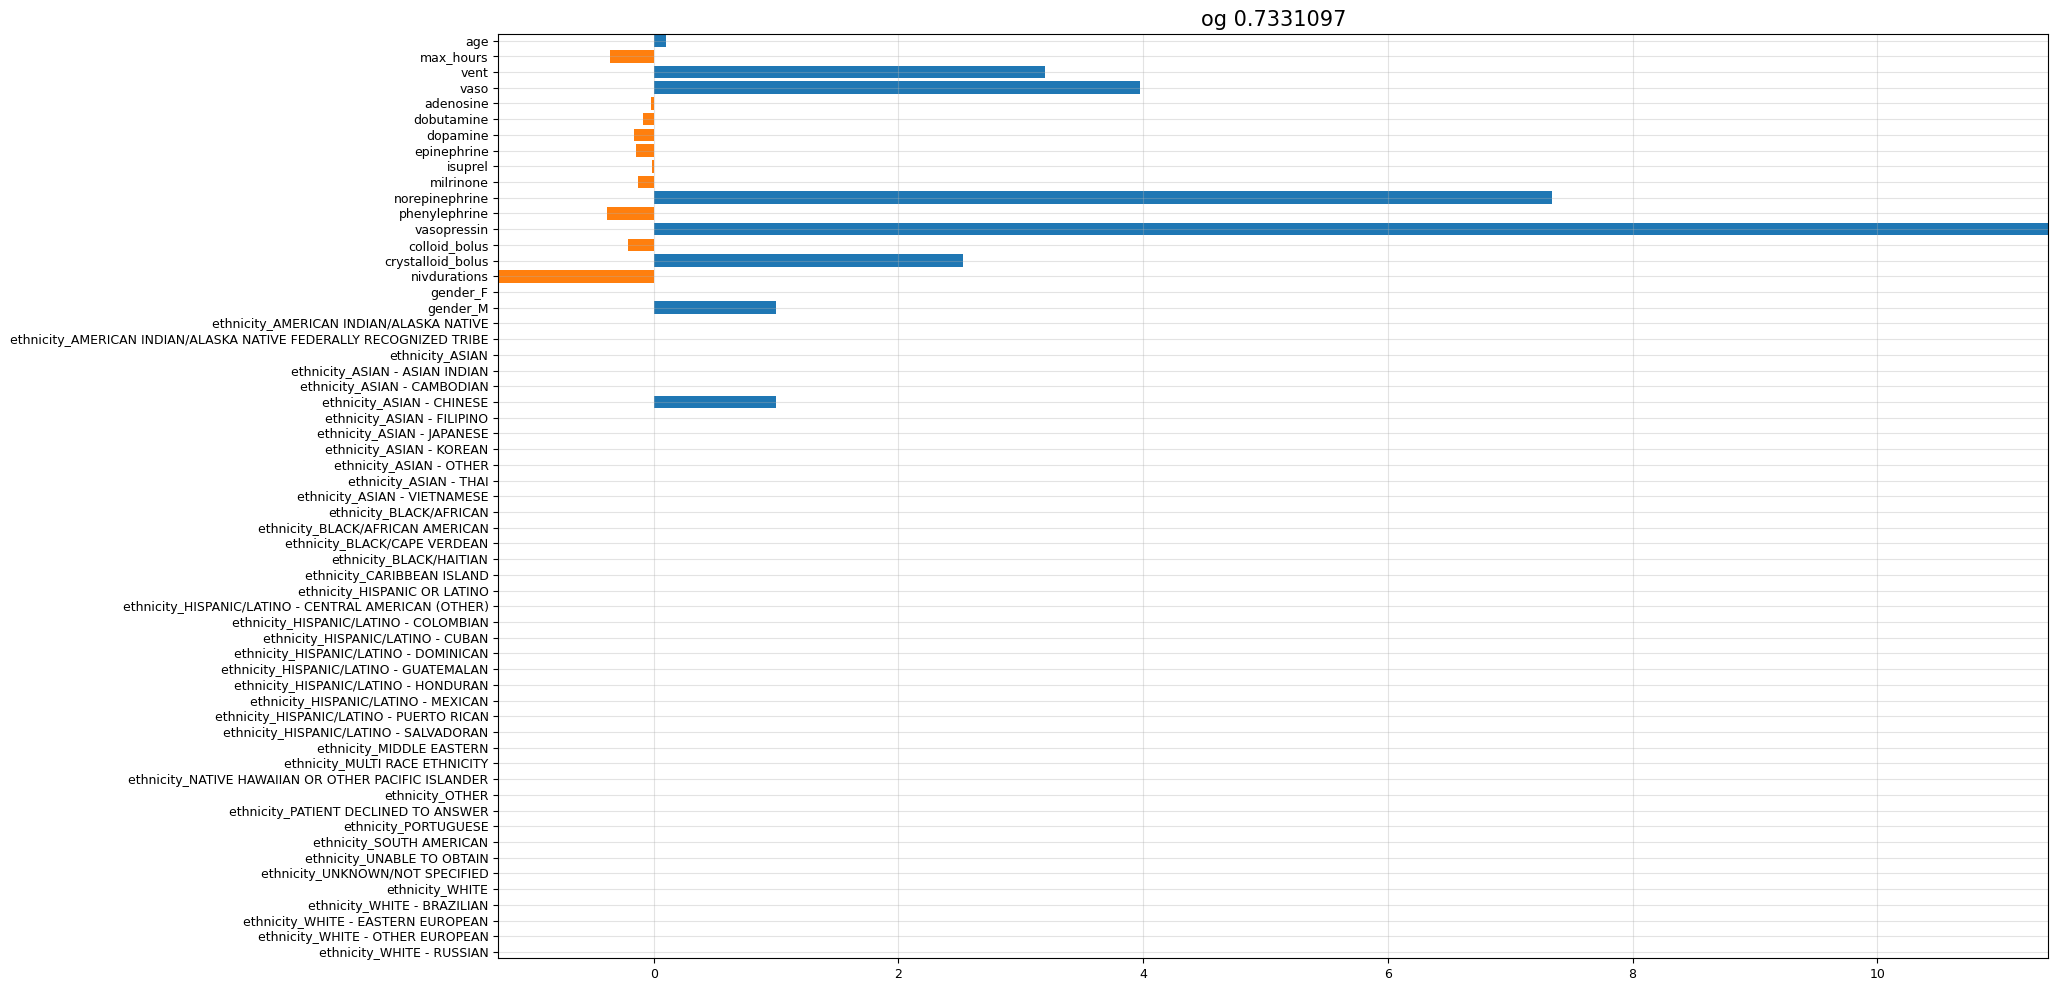

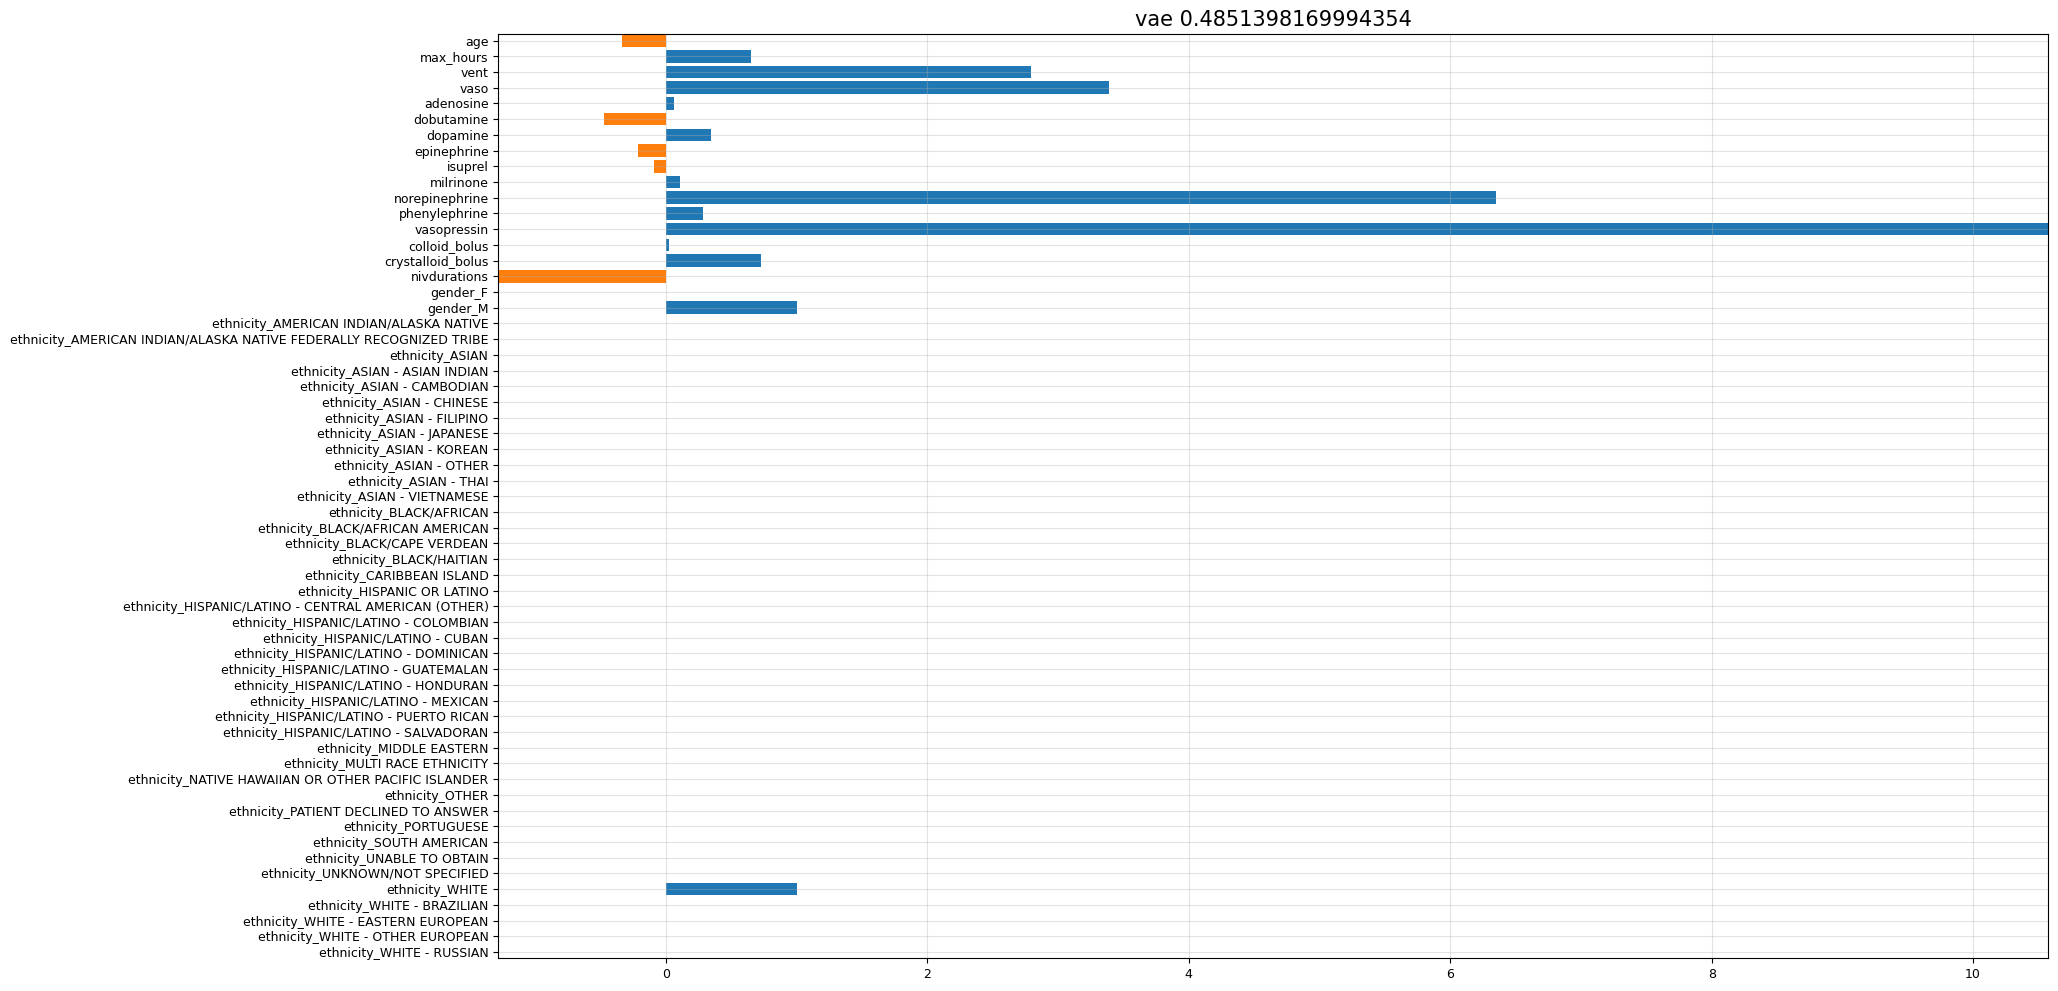

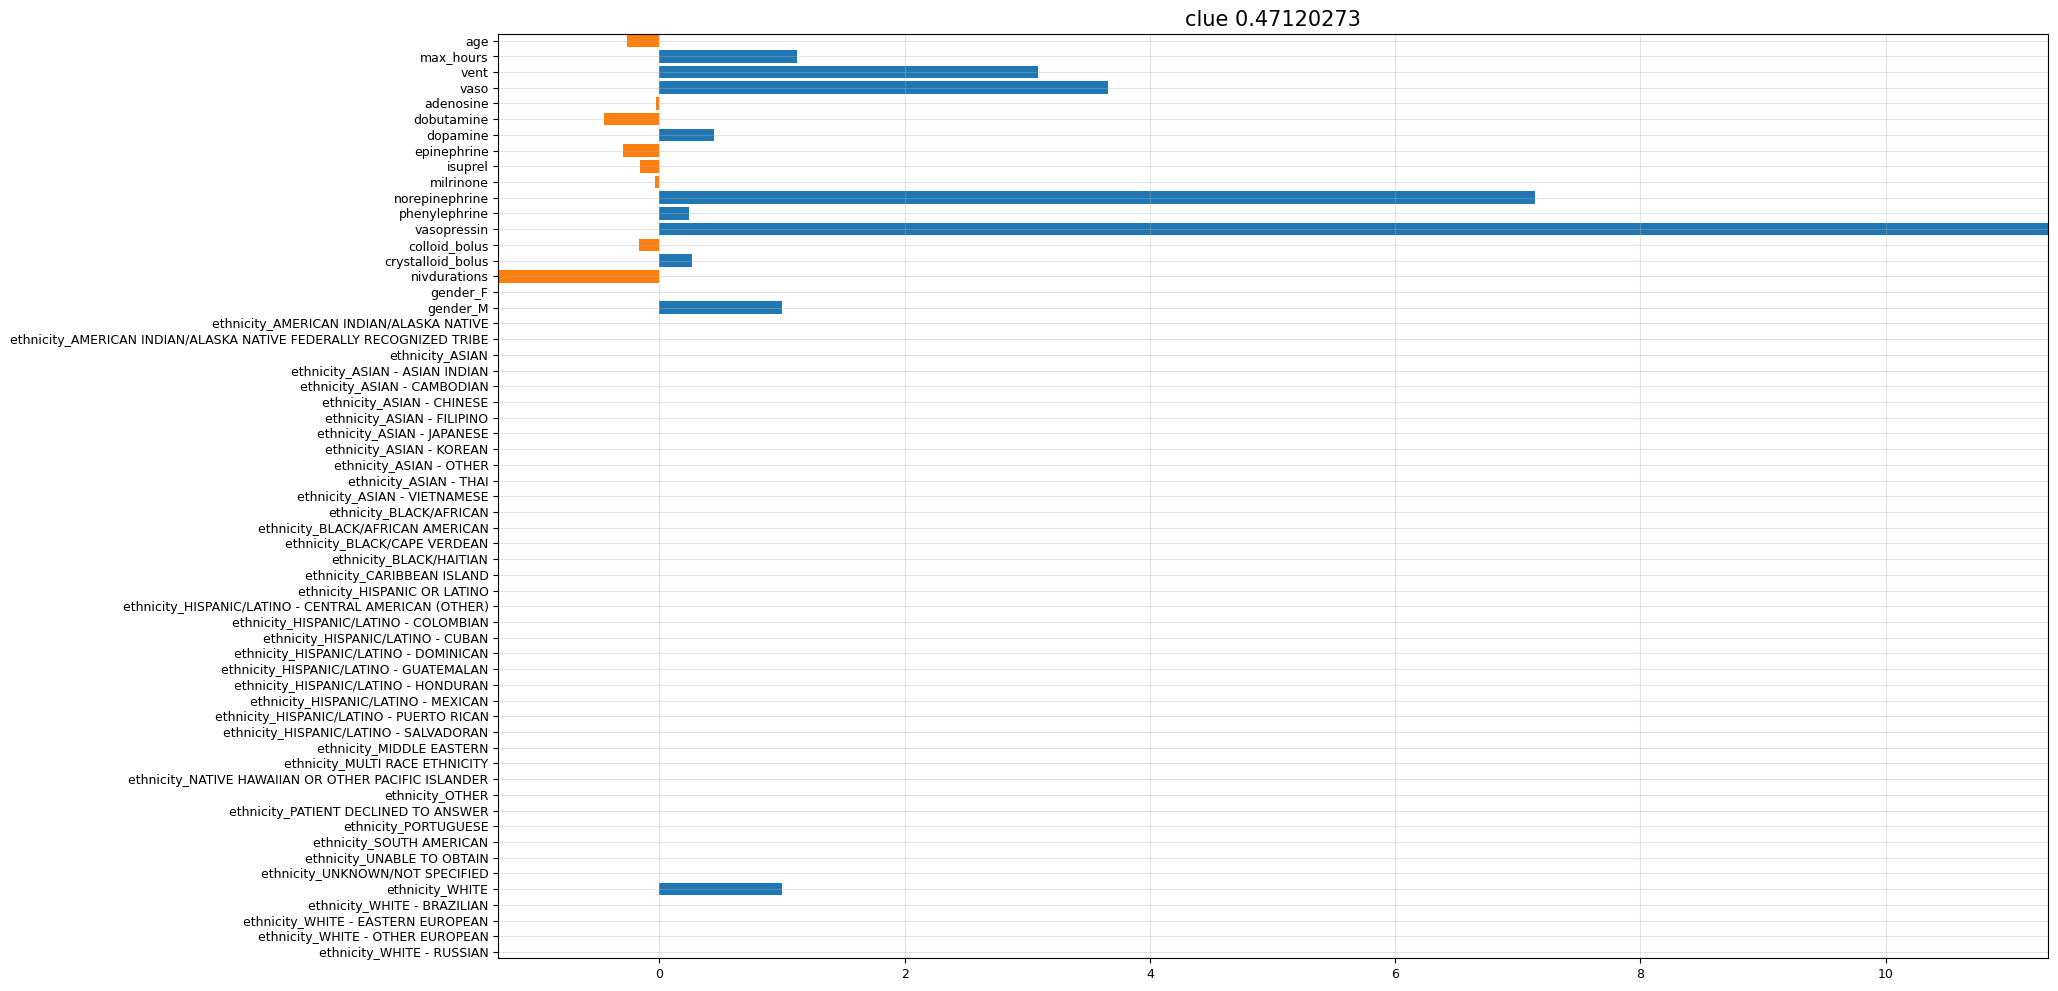

In [14]:
from counterfactual_xai.methods.interpretation import gen_bar_plot

Nsample = 1

print('o pred; ', desired_preds[Nsample, 0], 'pred; ', post_preds[Nsample, 0])

gen_bar_plot(var_names_flat[dname], x_init_batch[Nsample], title='og ' + str(te_uncertainty_vec[use_index[Nsample]]),
             xlabel=None, ylabel=None, probs=False, hor=True, save_file=None,
             max_fields=62, fs=9, verbose=False, sort=False, dpi=100, neg_color=True, ax=None, c=None)

gen_bar_plot(var_names_flat[dname], x_vec[0, Nsample, :], title='vae ' + str(uncertainty_vec[0, Nsample]), xlabel=None,
             ylabel=None, probs=False, hor=True, save_file=None, max_fields=62, fs=9, verbose=False, sort=False, dpi=100,
             neg_color=True, ax=None, c=None)

gen_bar_plot(var_names_flat[dname], x_vec[-1, Nsample, :],
             title='clue ' + str(post_uncert.detach().cpu().numpy()[Nsample]),
             xlabel=None, ylabel=None, probs=False, hor=True, save_file=None,
             max_fields=62, fs=9, verbose=False, sort=False, dpi=100, neg_color=True, ax=None, c=None)